In [1]:
import csv
import math
import patsy 
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import utils
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
# %matplotlib inline

C:\Users\tjdal\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# dss_team_project

## [House Price: Adcanced Regressin Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
+ team lucky
  + 권순호, 지성민, 김동현

+ Goal
	* it is your job to predict the sales price for each house.
	* For each Id in test set, you must predict the value of the SalePrice variable.

+ Metric
	* submissions are evaluated in Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.(Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally)

+ porject index
	* EDA(Exploratory data analysis)
	* Feature selection
	* Modeling(OLS Regression)
	* Model selection
	* Project 발표


## data describe & target describe

In [2]:
# target feature인 SslePrice를 dfy 변수로 지정
# SalePrice를 제외한 traing data를 dfX 변수로 지정
# 기준 index로 잡은 Id feature의 value 재설정 (전체 데이터 중 일부를 추출한 데이터이기 때문에 연속적이지 않음)       
df = pd.read_csv('./data/train.csv')
df['Id'] = np.where(df['Id']>0, range(0,1029+1), df['Id'])
df = df.set_index("Id")

dfy = pd.DataFrame(df, columns=['SalePrice'])
dfX = df.drop('SalePrice', axis=1)

df = pd.concat([dfX, dfy], axis=1)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1025,90,RL,60.0,9000,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,2Story,5,5,1974,1974,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,896,896,GasA,TA,Y,SBrkr,896,896,0,1792,0,0,2,2,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,32,45,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal,136000
1026,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2008,2009,Gable,CompShg,CemntBd,CmentBd,Stone,194.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1573,1573,GasA,Ex,Y,SBrkr,1578,0,0,1578,0,0,2,0,3,1,Ex,7,Typ,1,Gd,Attchd,2008.0,Fin,3,840,TA,TA,Y,0,36,0,0,0,0,NaN,NaN,NaN,0,5,2009,New,Partial,287090
1027,20,RL,90.0,17217,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1140,1140,GasA,Ex,Y,SBrkr,1140,0,0,1140,0,0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,36,56,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml,84500
1028,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,410,Unf,0,811,1221,GasA,Ex,Y,SBrkr,1221,0,0,1221,1,0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2004.0,RFn,2,400,TA,TA,Y,0,113,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,185000
1029,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
dfX['LotFrontage'] = dfX['LotFrontage'].fillna(dfX['LotFrontage'].median())
dfX['MasVnrArea'] = dfX['MasVnrArea'].fillna(0)

In [4]:
df = pd.concat([dfX, dfy], axis=1)

In [9]:
df['BsmtUnfSF'] = np.log(df['BsmtUnfSF'])
df['LotArea'] = np.log(df['LotArea'])

C:\Users\tjdal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [12]:
grade_col=['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual', "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
df[grade_col] = df[grade_col].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'], [5,4,3,2,1,0]).fillna(0)
df['BsmtExposure'] = df['BsmtExposure'].replace(['Gd', 'Av', 'Mn', 'No', 'Na'],[4,3,2,1,0]).fillna(0)
df[['BsmtFinType1', 'BsmtFinType2']] = df[['BsmtFinType1', 'BsmtFinType2']].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ','Unf', 'NA'],[6,5,4,3,2,1,0]).fillna(0)
df['Functional'] = df['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],[7,6,5,4,3,2,1,0]).fillna(0)
df["GarageFinish"] = df["GarageFinish"].replace(['Fin', 'RFn', 'Unf', 'NA'],[3,2,1,0]).fillna(0)
df["Fence"] = df["Fence"].replace(['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA' ],[4,3,2,1,0]).fillna(0)

# Modeling(OLS Regression)

In [26]:
# 1차 feature selection 한 변수 구분
select_feat = ['OverallQual', 'PoolArea', 'MasVnrArea', 'GrLivArea', 'Neighborhood', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageArea',
               'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'YearRemodAdd', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']
df_sel = df[select_feat]
df_sels = pd.concat([df_sel, dfy], axis=1)
df_sels.head()

,OverallQual,PoolArea,MasVnrArea,GrLivArea,Neighborhood,Foundation,ExterQual,BsmtQual,GarageArea,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,YearRemodAdd,FullBath,TotRmsAbvGrd,Fireplaces,SalePrice
Id,,,,,,,,,,,,,,,,,,
0,7,0,196.0,1710,CollgCr,PConc,4,4.0,548,5,4,0.0,2.0,2003,2,8,0,208500
1,6,0,0.0,1262,Veenker,CBlock,3,4.0,460,5,3,3.0,2.0,1976,2,6,1,181500
2,7,0,162.0,1786,CollgCr,PConc,4,4.0,608,5,4,3.0,2.0,2002,2,6,1,223500
3,7,0,0.0,1717,Crawfor,BrkTil,3,3.0,642,4,4,4.0,1.0,1970,1,7,1,140000
4,8,0,350.0,2198,NoRidge,PConc,4,4.0,836,5,4,3.0,2.0,2000,2,9,1,250000


In [27]:
# 1차 selection 한 변수의 ols
result_sel = sm.OLS.from_formula("np.log(SalePrice) ~ OverallQual + PoolArea + MasVnrArea + GrLivArea + C(Neighborhood) + C(Foundation) +"
                                 "ExterQual + BsmtQual + HeatingQC + KitchenQual + FireplaceQu + GarageFinish + GarageArea + "
                                 "YearRemodAdd + FullBath + TotRmsAbvGrd + Fireplaces", df_sels).fit()
print(result_sel.summary())
# P>|t| 값이 높은 변수들이 아직 많음!

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     142.8
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        19:04:57   Log-Likelihood:                 520.73
No. Observations:                1030   AIC:                            -951.5
Df Residuals:                     985   BIC:                            -729.3
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

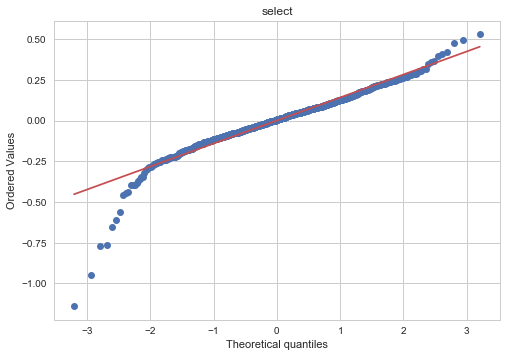

In [28]:
# 정규성을 QQ plot으로 확인해자 
sp.stats.probplot(result_sel.resid, plot=plt)
plt.title('select')  
plt.show()

In [29]:
# 정규성 검정 -> 당연히 0.000 
test = sms.omni_normtest(result_sel.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 305.579
P-value     :  0.000


In [30]:
# MasVnrArea 변수 제거
model_sel2  = sm.OLS.from_formula("np.log(SalePrice) ~ OverallQual + PoolArea + GrLivArea + C(Neighborhood) + C(Foundation) +"
                                 "ExterQual + BsmtQual + HeatingQC + KitchenQual + FireplaceQu + GarageFinish + YearRemodAdd + "
                                 "FullBath + TotRmsAbvGrd + Fireplaces + GarageArea", df_sels)
result_sel2 = model_sel2.fit()
print(result_sel2.summary())
# P>|t| 값이 높은 변수들이 아직 많음!

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     146.2
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        19:05:00   Log-Likelihood:                 520.66
No. Observations:                1030   AIC:                            -953.3
Df Residuals:                     986   BIC:                            -736.1
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [31]:
# FireplaceQu 제거, Foundation 제거
R_style = "np.log(SalePrice) ~ scale(OverallQual) + scale(PoolArea) + scale(GrLivArea) + C(Neighborhood) + \
                                 scale(BsmtQual) + scale(KitchenQual) + scale(GarageFinish) + scale(YearRemodAdd) + \
                                 scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(GarageArea)"
model_sel2  = sm.OLS.from_formula(R_style, df_sels)

result_sel2 = model_sel2.fit()
print(result_sel2.summary())
# P>|t| 값이 높은 변수들이 아직 많음!

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     181.8
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        19:05:01   Log-Likelihood:                 509.18
No. Observations:                1030   AIC:                            -948.4
Df Residuals:                     995   BIC:                            -775.6
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [32]:
# Cross-Validation을 통해 rmse값 확인
outcome, predictors = patsy.dmatrices(R_style, df_sels)
model_cross = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=0)
rmse1 = np.sqrt(-cross_val_score(model_cross, predictors, outcome, scoring="neg_mean_squared_error", cv=cv))
rmse1

array([  1.77603725e-01,   1.45302838e-01,   2.22017285e-01,
         1.84074129e-01,   1.38131227e-01,   1.50274500e-01,
         1.40849511e-01,   3.18674232e+10,   1.34907311e-01,
         1.16434889e-01])

In [33]:
rmse1.mean()

3186742323.9670219

In [34]:
# PoolArea 제거
R_style = "np.log(SalePrice) ~ scale(OverallQual) + scale(GrLivArea) + C(Neighborhood) + \
                                 scale(BsmtQual) + scale(KitchenQual) + scale(GarageFinish) + scale(YearRemodAdd) + \
                                 scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(GarageArea)"

model_sel2  = sm.OLS.from_formula(R_style, df_sels)

result_sel2 = model_sel2.fit()
print(result_sel2.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     182.3
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        19:05:05   Log-Likelihood:                 496.58
No. Observations:                1030   AIC:                            -925.2
Df Residuals:                     996   BIC:                            -757.3
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
# Cross-Validation을 통해 rmse값 확인
outcome, predictors = patsy.dmatrices(R_style, df_sels)
model_cross = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=0)
rmse2 =np.sqrt(-cross_val_score(model_cross, predictors, outcome, scoring="neg_mean_squared_error", cv=cv))
rmse2

array([ 0.15783049,  0.14111653,  0.22571515,  0.18184552,  0.13994902,
        0.15110291,  0.14098337,  0.1455198 ,  0.13379029,  0.11828733])

In [36]:
rmse2.mean()

0.1536140402452581

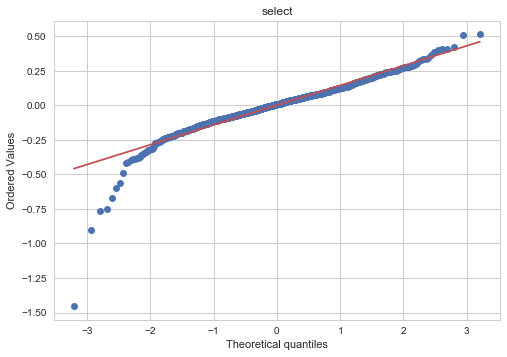

In [37]:
sp.stats.probplot(result_sel2.resid, plot=plt)
plt.title('select')  
plt.show()

In [38]:
# ols로 제거할수있는 변수 모두 제거
select2_feat = ['OverallQual', 'GrLivArea', 'Neighborhood', 'BsmtQual', 'KitchenQual', 
               'GarageFinish', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'SalePrice']

In [39]:
df_sel2 = df[select2_feat]
df_sel2.head()

,OverallQual,GrLivArea,Neighborhood,BsmtQual,KitchenQual,GarageFinish,YearRemodAdd,TotRmsAbvGrd,Fireplaces,GarageArea,SalePrice
Id,,,,,,,,,,,
0,7,1710,CollgCr,4.0,4,2.0,2003,8,0,548,208500
1,6,1262,Veenker,4.0,3,2.0,1976,6,1,460,181500
2,7,1786,CollgCr,4.0,4,2.0,2002,6,1,608,223500
3,7,1717,Crawfor,3.0,4,1.0,1970,7,1,642,140000
4,8,2198,NoRidge,4.0,4,2.0,2000,9,1,836,250000


In [40]:
df_sel2[ df_sel2['Neighborhood'] == 'Blueste']['Neighborhood'].index

Int64Index([429], dtype='int64', name='Id')

In [41]:
# 레버리지가 큰 아웃라이어 판별
influence = result_sel2.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(dfy) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

In [42]:
# 레버리지가큰 아웃라이어 변수 index리스트
idx = [3,   18,   37,  131,  158,  199,  212,  225,  265,  299,  318, 329,  345,  359,  367,  378,  391,  416,  419,  437,  453, 455, 
       456,  458,  474,  477,  482,  486,  490,  494,  497,  500, 508,  513,  515,  525,  533,  577,  643,  657,  658,  717,  719, 725,  
       733,  734,  747,  749,  772,  920,  924,  944,  946,  951, 983, 1019, 1027]

In [43]:
# 레버리지가큰 아웃라이어 drop
df_sel2.drop(df.index[[idx]], inplace=True)

C:\Users\tjdal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
df_sel2.head()

,OverallQual,GrLivArea,Neighborhood,BsmtQual,KitchenQual,GarageFinish,YearRemodAdd,TotRmsAbvGrd,Fireplaces,GarageArea,SalePrice
Id,,,,,,,,,,,
0,7,1710,CollgCr,4.0,4,2.0,2003,8,0,548,208500
1,6,1262,Veenker,4.0,3,2.0,1976,6,1,460,181500
2,7,1786,CollgCr,4.0,4,2.0,2002,6,1,608,223500
4,8,2198,NoRidge,4.0,4,2.0,2000,9,1,836,250000
5,5,1362,Mitchel,4.0,3,1.0,1995,5,0,480,143000


In [45]:
# 레버리지가 큰 아웃라이어를 제거한 모델
R_style = "np.log(SalePrice) ~ scale(OverallQual) + scale(GrLivArea) + C(Neighborhood) +  \
                                 scale(BsmtQual) + scale(KitchenQual) + scale(GarageFinish) + scale(YearRemodAdd) + \
                                 scale(TotRmsAbvGrd) + scale(Fireplaces)+ scale(GarageArea)"

model_sel3  = sm.OLS.from_formula(R_style, df_sel2)

result_sel3 = model_sel3.fit()
print(result_sel3.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     291.6
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        19:07:21   Log-Likelihood:                 764.22
No. Observations:                 973   AIC:                            -1460.
Df Residuals:                     939   BIC:                            -1294.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [46]:
outcome, predictors = patsy.dmatrices(R_style, df_sel2)

model_cross = LinearRegression()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
rmse3 = np.sqrt(-cross_val_score(model_cross, predictors, outcome, scoring="neg_mean_squared_error", cv=cv))
rmse3

array([ 0.10855554,  0.12124978,  0.11172996,  0.10363056,  0.11035734,
        0.11669988,  0.1203044 ,  0.12015278,  0.11755174,  0.11060344])

In [47]:
rmse3.mean()

0.11408354169533777

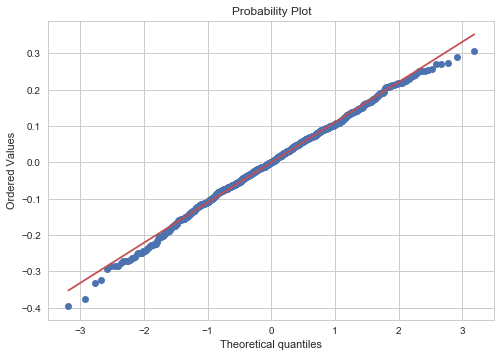

In [48]:
# QQplot 확인
sp.stats.probplot(result_sel3.resid, plot=plt)
plt.show()

In [49]:
# 1%로 채택....
test = sms.omni_normtest(result_sel3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  7.613
P-value     :  0.022


* 다항회귀 분석을 3차까지 greedy방식으로 시도해봤으나 Adj. R-squared 값이 오히려 내려감

# test data

In [51]:
df_test = pd.read_csv('./data/test.csv')
in_dex = df_test['Id']
df_test = df_test.set_index("Id")


grade_col=['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual', "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
df_test[grade_col] = df_test[grade_col].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'], [5,4,3,2,1,0]).fillna(0)
df_test['BsmtExposure'] = df_test['BsmtExposure'].replace(['Gd', 'Av', 'Mn', 'No', 'Na'],[4,3,2,1,0]).fillna(0)
df_test[['BsmtFinType1', 'BsmtFinType2']] = df_test[['BsmtFinType1', 'BsmtFinType2']].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ','Unf', 'NA'],[6,5,4,3,2,1,0]).fillna(0)
df_test['Functional'] = df_test['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],[7,6,5,4,3,2,1,0]).fillna(0)
df_test["GarageFinish"] = df_test["GarageFinish"].replace(['Fin', 'RFn', 'Unf', 'NA'],[3,2,1,0]).fillna(0)
df_test["Fence"] = df_test["Fence"].replace(['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA' ],[4,3,2,1,0]).fillna(0)
df_test['BsmtUnfSF'] = np.log(df_test['BsmtUnfSF'])
df_test['LotArea'] = np.log(df_test['LotArea'])

C:\Users\tjdal\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [52]:
df_test_SalePrice = np.exp(result_sel3.predict(df_test))

df_test_SalePrice.tail()

Id
1453    138423.315169
1456    178187.978246
1457    207664.358405
1458    252995.794788
1460    119944.385171
dtype: float64

In [53]:
with open('House_Price_answer.csv', 'w') as csvfile:
    fieldnames = ['Id', 'SalePrice']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in df_test_SalePrice.index:
        writer.writerow({'Id' : i, 'SalePrice' : df_test_SalePrice.loc[i]})

# Team Answer

In [54]:
print(result_sel3.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     291.6
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        19:17:02   Log-Likelihood:                 764.22
No. Observations:                 973   AIC:                            -1460.
Df Residuals:                     939   BIC:                            -1294.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [55]:
df_test_answer = pd.read_csv('./data/test_answer_house_prices_advanced.csv').set_index("Id")

df_test_answer['SalePrice'].tail()

Id
1453    145000
1456    175000
1457    210000
1458    266500
1460    147500
Name: SalePrice, dtype: int64

In [56]:
y_pred = np.array(df_test_SalePrice)
y_test = np.array(df_test_answer['SalePrice'])
team_answer = mean_squared_error(y_test, y_pred)**0.5
team_answer

25776.065480956331

In [57]:
df_test_Sale = result_sel3.predict(df_test)
df_test_log_answer = np.log(df_test_answer['SalePrice'])
(((df_test_Sale - df_test_log_answer) ** 2).mean()) ** 0.5

0.14847608931985304